# ML Model for Auto Insurance Industry

The aim of the project is to build a Machine Learning Model to predict whether an owner will initiate an auto insurance claim in the next year.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train(1).csv


In [2]:
import pandas as pd
import numpy as np
import plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import math
import sklearn
import statsmodels.api as sm 

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix,mean_squared_error,accuracy_score, classification_report
from sklearn.metrics import precision_score,recall_score,roc_auc_score,f1_score,cohen_kappa_score
from sklearn.model_selection import train_test_split as tts
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from IPython.display import Markdown, display
from matplotlib.pyplot import xticks
%matplotlib inline

In [3]:
sns.set_palette('cubehelix')
pd.set_option('display.max_columns', 100)
py.offline.init_notebook_mode(connected=True)
pd.options.display.float_format = '{:20,.2f}'.format 
path_to_csv = '/kaggle/input/train(1).csv'

In [4]:
def pairplot(x_axis,y_axis) :
    sns.pairplot(car_df,x_vars=x_axis,y_vars=y_axis,height=4,aspect=1,kind="scatter")
    plt.show()

def heatmap(x,y,dataframe):
    plt.figure(figsize=(x,y))
    sns.heatmap(dataframe.corr(),cmap="OrRd",annot=True)
    plt.show()

def bar_count_plot(dataframe,col_name) :
    plt.figure(figsize=(16,8))
    plt.title(col_name + 'Histogram')
    sns.countplot(dataframe[col_name], palette=("plasma"))
    xticks(rotation = 90)
    plt.show()

def accuracy_result(y_test, y_pred_test):
    cm = sklearn.metrics.confusion_matrix(y_test, y_pred_test)
    TP, TN = cm[1, 1], cm[0, 0]
    FP, FN = cm[0, 1], cm[1, 0]
    fpr = round(FP / (TN + FP), 3)
    recall = round(sklearn.metrics.recall_score(y_test, y_pred_test), 3)
    precision = round(sklearn.metrics.precision_score(y_test, y_pred_test), 3)
    specificity = round(TN / (TN + FP), 3)
    accuracy = round(sklearn.metrics.accuracy_score(y_test, y_pred_test), 3)
    roc_auc = round(roc_auc_score(y_test, y_pred_test), 3)
    cohen_kappa = round(cohen_kappa_score(y_test, y_pred_test), 3)
    f1_score_ = round(f1_score(y_test, y_pred_test), 3)

    print('\n CONFUSION MATRIX:\n ', cm, '\n')
    print('FPR: ', fpr)
    print('TPR/ RECALL/ SENSTIVITY: ', recall)
    print('PRECISION:' , precision)
    print('SPECIFICITY: ', specificity)
    print('ACCURACY: ', accuracy)
    print('ROC AUC: ', roc_auc)
    print('Cohens kappa: ', cohen_kappa)
    print('F1 score: ', f1_score_)
    print('\n CLASSIFICATION REPORT: \n', classification_report(y_test, y_pred_test))

    
def print_log(string):
    display(Markdown("**<span style='color:green'>"+string+"</span>**"))

def header(string):
    display(Markdown("+-+-+-+"))
    display(Markdown("### "+string))

def get_variable_type(element):
    """
    Check if column is of continuous or categorical variable.
    Assumes that if unique count < 20 then categorical, else continuous.
    """
    if element == 0:
        return "Not Known"
    return "Categorical" if element < 20 else "Continuous"

def predict_variable_type(metadata_matrix):
    metadata_matrix["Variable_Type"] = metadata_matrix["Unique_Values_Count"].apply(get_variable_type).astype(str)
    metadata_matrix["frequency"] = metadata_matrix["Null_Count"] - metadata_matrix["Null_Count"]
    metadata_matrix["frequency"].astype(int)
    return metadata_matrix 

def get_meta_data(dataframe):
    """
     Method to get Meta-Data about any dataframe passed 
    """
    metadata_matrix = pd.DataFrame({
        'Datatype': dataframe.dtypes.astype(str),  # data types of columns
        'Non_Null_Count': dataframe.count(axis=0).astype(int),  # total elements in columns
        'Null_Count': dataframe.isnull().sum().astype('Int64'),  # total null values in columns
        'Null_Percentage': dataframe.isnull().sum() / len(dataframe) * 100,  # percentage of null values
        'Unique_Values_Count': dataframe.nunique().astype(int)  # number of unique values
    })

    metadata_matrix = predict_variable_type(metadata_matrix)
    return metadata_matrix


def plot_data_pie_chat(dataframe,col):
    header("Stats for "+col+" Datatype Percentage Distribution")
    dataframe_group = dataframe[col].value_counts().reset_index()
    trace = go.Pie(labels=dataframe_group[col], values=dataframe_group[col].value_counts())
    layout = go.Layout(title="Datatype Percentage Distribution")
    fig = go.Figure(data=[trace], layout=layout)    
    py.offline.iplot(fig)

In [5]:
df = pd.read_csv(path_to_csv)
df1= df.copy()
df.sample(n=5)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
525007,1311843,0,1,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.10,0.20,-1.00,11,1,-1,0,-1,1,1,1,2,1,40,2,0.36,0.65,0.43,2.24,0.30,0.50,0.10,1,2,9,2,9,3,9,11,2,2,8,0,1,1,1,1,0
416929,1042182,0,2,1,1,0,0,0,0,1,0,0,0,0,0,0,7,1,0,0,0.80,0.20,0.44,7,1,1,0,1,10,1,1,2,1,89,2,0.39,0.89,0.34,3.16,0.00,0.10,0.30,4,2,6,2,8,1,14,5,1,1,5,0,1,1,0,0,0
371601,928809,0,0,1,2,1,0,0,1,0,0,0,0,0,0,0,4,0,0,1,0.70,0.60,1.18,11,0,0,8,1,4,1,0,2,1,6,3,0.45,1.16,0.36,3.74,0.20,0.20,0.40,0,3,6,5,9,4,11,9,5,0,3,0,1,0,0,0,0
36773,92134,0,3,1,4,1,0,0,0,0,1,0,0,0,0,0,4,1,0,0,0.60,0.20,-1.00,6,1,-1,0,1,0,1,1,0,1,62,3,0.40,0.83,0.38,3.16,0.00,0.60,0.70,3,0,9,5,7,1,10,7,5,3,0,0,1,0,1,1,0
415498,1038592,0,2,1,8,0,1,1,0,0,0,0,0,0,0,0,9,1,0,0,0.90,0.40,0.77,11,1,-1,0,-1,14,1,1,2,1,42,2,0.40,0.65,0.39,2.45,0.70,0.50,0.40,2,2,7,5,8,3,7,2,2,1,11,1,0,1,0,0,0


In [6]:
df.to_csv('train.csv', encoding='utf-8', index=False)

In [7]:
temp = df[:200000]
_X = temp.drop(['id','target'],axis =1)
_y = temp.target
meta_matrix_df = get_meta_data(df)
meta_matrix_df["dt_name"] =[ i.split("_")[-1] for i in meta_matrix_df.index.values]
meta_matrix_df['dt_name'] = meta_matrix_df['dt_name'].apply(lambda x : "interval" if str(x).isnumeric() else x)

In [8]:
Dtype = meta_matrix_df.groupby(['dt_name'])

interval_feature =Dtype.get_group("interval").index.tolist()
bin_feature = Dtype.get_group("bin").index.tolist()
cat_feature = Dtype.get_group("cat").index.tolist()

#### 1. Write at least 3 important inferences from the data above

**Ans.:**


1. The data is very uneven, and the desired distribution is:

    $0 = 96.36 %$
    
    $1 = 3.64 %$
    
2. data have vaiable type:

    $ Interval = 45.6$
    
    $ Binary = 29.8$
    
    $ Categorical = 24.6$

3. The vast majority of the characteristics have no correlation.
    

#### 2. Is the data balanced? Meaning are targets 0 and 1 in the right proportion?

***Ans: No, data not balanced. I will show you below.***

Percentge distribution of class '1' & class '0':

 0                  96.36
1                   3.64
Name: target, dtype: float64


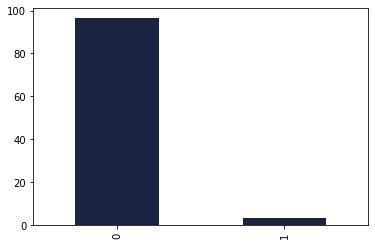

In [9]:
perc = (df['target'].value_counts()/(df.shape[0]))*100
print("Percentge distribution of class '1' & class '0':\n\n",perc)
perc.plot.bar();

#### 3. How many categorical features are there?

In [10]:
group_variable_type = meta_matrix_df.groupby('Variable_Type')
print("categorical features count:",group_variable_type.get_group('Categorical').shape[0])

categorical features count: 50


#### 4. How many binary features are there? 

In [11]:
total_variables = meta_matrix_df.shape[0]
continuous_variables = (meta_matrix_df['Variable_Type'] == 'Continuous').sum()
binary_variables = total_variables - continuous_variables

print("binary features count:", binary_variables)

binary features count: 50


#### 5. Write inferences from data on interval variables

***Ans: Looking at the plot, we can see that almost all of the characteristics are independent of one another. Just three of the features have correlations that are close to 0.5.***

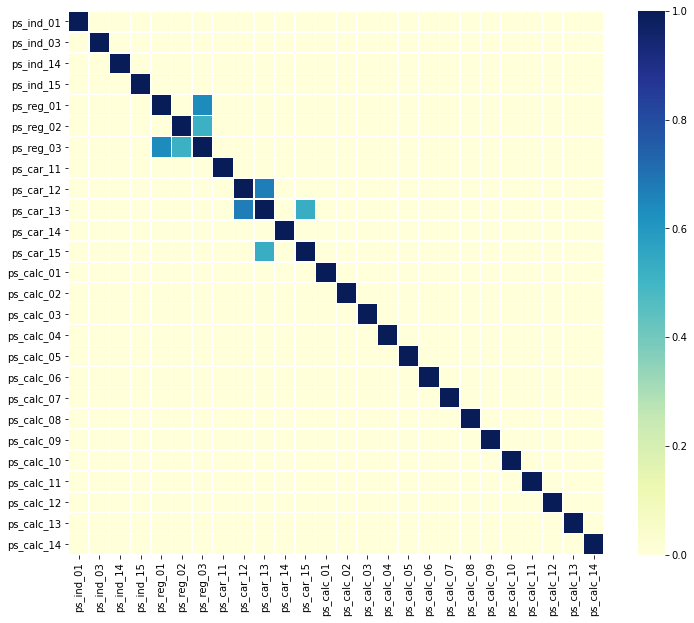

In [12]:
temp = df[interval_feature].corr()
temp = temp[(temp>=0.5) | (temp<=-0.5)].fillna(0)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(temp,linewidths=.5, cmap="YlGnBu",ax=ax)
plt.show()

In [13]:
print_log("Analysis :Looking at the plot, we can see that almost all of the characteristics are independent of one another. Just three of the features have correlations that are close to 0.5.")

**<span style='color:green'>Analysis :Looking at the plot, we can see that almost all of the characteristics are independent of one another. Just three of the features have correlations that are close to 0.5.</span>**

#### 6. Write inferences from data on ordinal variables.

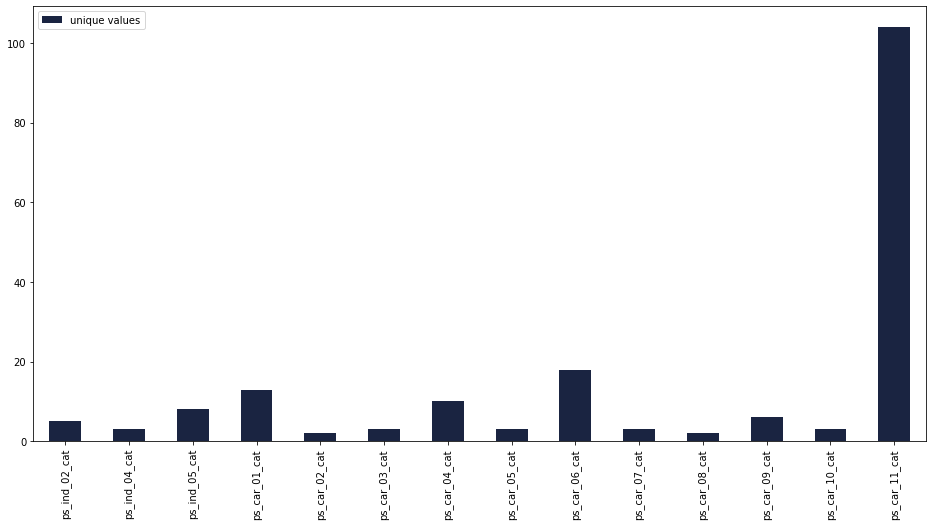

In [14]:
d ={}
for i in df[cat_feature].columns:
    d[i] = df[cat_feature][i].nunique()

pd.DataFrame(d,index=['unique values']).T.plot.bar(figsize=(16,8));

In [15]:
print_log("Analysis : Looking at above graph only one feature have unqiue values more than 20")

**<span style='color:green'>Analysis : Looking at above graph only one feature have unqiue values more than 20</span>**

#### 7. Write inferences from data on binary variables.

**<span style='color:green'>Analysis : Looking at above graph % of 1's is near near for *ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin.</span>**

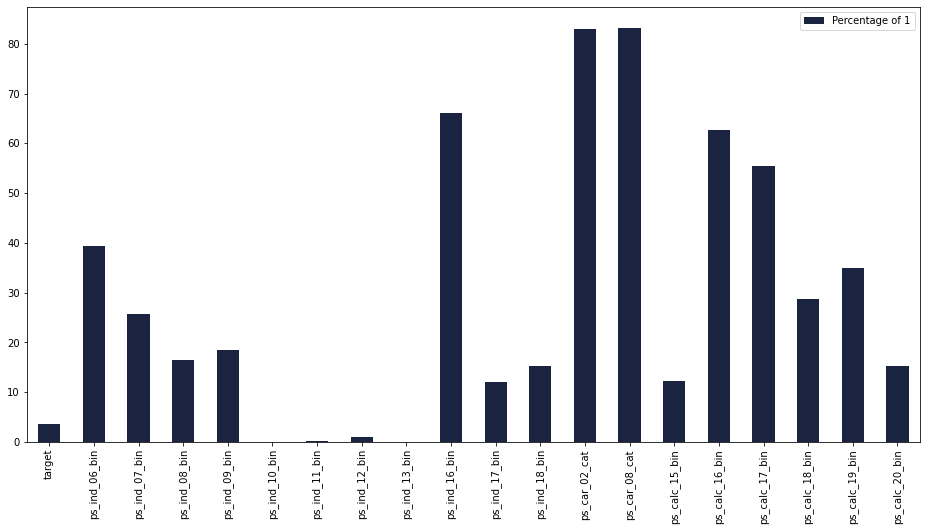

In [16]:
col = meta_matrix_df[meta_matrix_df['Unique_Values_Count'] == 2].index
df_1 = pd.DataFrame((df[col].sum()/df[col].shape[0])*100, columns=['Percentage of 1'])
df_1.plot.bar(figsize=(16,8));
print_log("Analysis : Looking at above graph % of 1's is near near for *ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin.");

#### 8. Check if the target data is proportionate or not. Hint: Below than 30% for binary data is sign of imbalance

Target=1 shape: (21694, 59) 3.64 % 
Target=0 shape: (573518, 59) 96.36 %

 # This Data shows that it's imbalanced


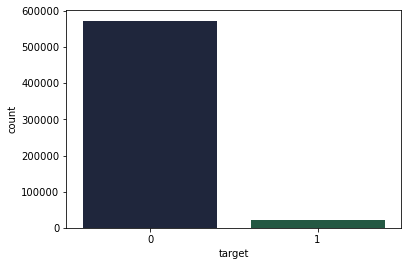

In [17]:
Per1= np.round((df[df['target']==1].shape[0]*100)/ df.shape[0],2)
Per0= np.round((df[df['target']==0].shape[0]*100)/ df.shape[0],2)

print('Target=1 shape:',df[df['target']==1].shape, Per1,'%','\nTarget=0 shape:',df[df['target']==0].shape,Per0,'%')
print("\n # This Data shows that it's imbalanced")
sns.countplot(x= df['target'])
plt.show()

#### 9. What should be the preferred way in this case to balance the data?

***Ans: The most popular solution to an imbalanced classification problem is to change the composition of the training dataset.Techniques designed to change the class distribution in the training dataset are generally referred to as sampling methods or resampling methods as we are sampling an existing data sample.***

***

#### 10. How many training records are there after achieving a balance of 12%?

***Ans: $642340$***

In [18]:
# using resampling technique, splittinf data into classes
df_mino= df[df['target']==1]
df_majo= df[df['target']==0]
df_mino_upsampled = resample(df_mino,replace=True,n_samples=int(len(df_majo)*0.12), random_state = 42)

print("Size of data, after achieving a balance of 12%: ", df_mino_upsampled.shape[0] + df_majo.shape[0])

Size of data, after achieving a balance of 12%:  642340


#### 11. Which are the top two features in terms of missing values?

***Ans: No Missing Value Found.***

***

#### 12. In total, how many features have missing values?

***Ans: No Feature having missing values***

***

#### 13. What steps should be taken to handle the missing data?

***Ans: N/A***

### Applying Resampling to make balance data-set

Class compostion after resampling:
1    573518
0    573518
Name: target, dtype: int64


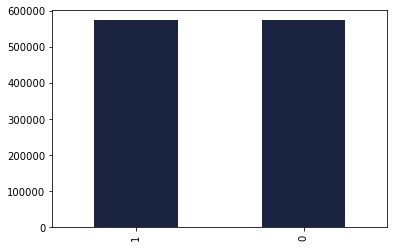

In [19]:
df_mino_upsampled = resample(df_mino,replace=True,n_samples=len(df_majo), random_state = 42)
df = pd.concat([df_majo,df_mino_upsampled])
print("Class compostion after resampling:")
print(df['target'].value_counts())
df['target'].value_counts().plot.bar();

***Now here we have both class with equal count***

#### 14. Which interval variables have strong correlation?

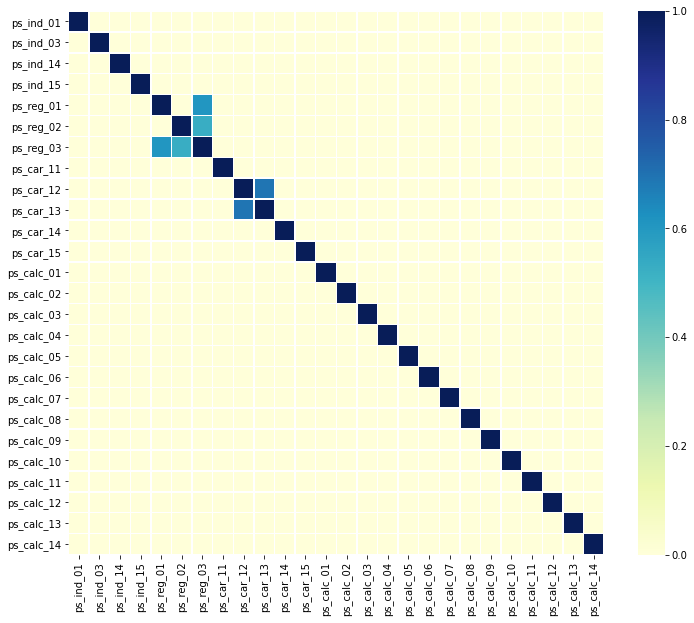

In [20]:
temp = df[interval_feature].corr()
temp = temp[(temp>=0.5) | (temp<=-0.5)].fillna(0)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(temp,linewidths=.5, cmap="YlGnBu",ax=ax)
plt.show()

***Ans: interval Variable with high correlation(`abs` value more than $0.5$)***
1. ps_reg_03 --> ps_reg_03 & ps_reg_03
2. ps_reg_13 --> ps_reg_12

***

#### 15. What's the level of correlation among ordinal features?

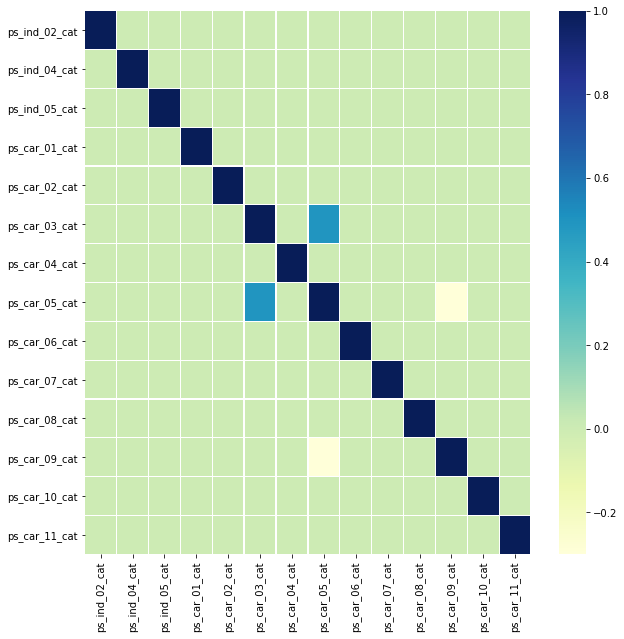

In [21]:
# cutoff = 0.3
temp = df[cat_feature].corr()
temp = temp[(temp>=0.3) | (temp<=-0.3)].fillna(0)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(temp,linewidths=.3, cmap="YlGnBu",ax=ax)
plt.show()

***Ans: Ordinal Variable with high correlation(`abs` value more than $0.5$)***
1. ps_car_03_cat --> ps_car_05_cat
2. ps_car_05_cat --> ps_car_09_cat

***

#### 16. Implement Hot Encoding for categorical features

***No, nominal Features are available***

***

#### 17. In nominal and interval features, which features are suitable for StandardScaler?

***Nominal featues are not suitable for `StandardScaler`***

In [22]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(_X,_y)

feature_imp = pd.Series(clf.feature_importances_,index=_X.columns).sort_values(ascending=False)
imp = pd.DataFrame(feature_imp).reset_index()
imp.columns = ["Features", 'Imp']

imp['Imp'] = (imp['Imp']/max(imp['Imp']))*100
col = imp[imp["Imp"]>25]['Features'].tolist()

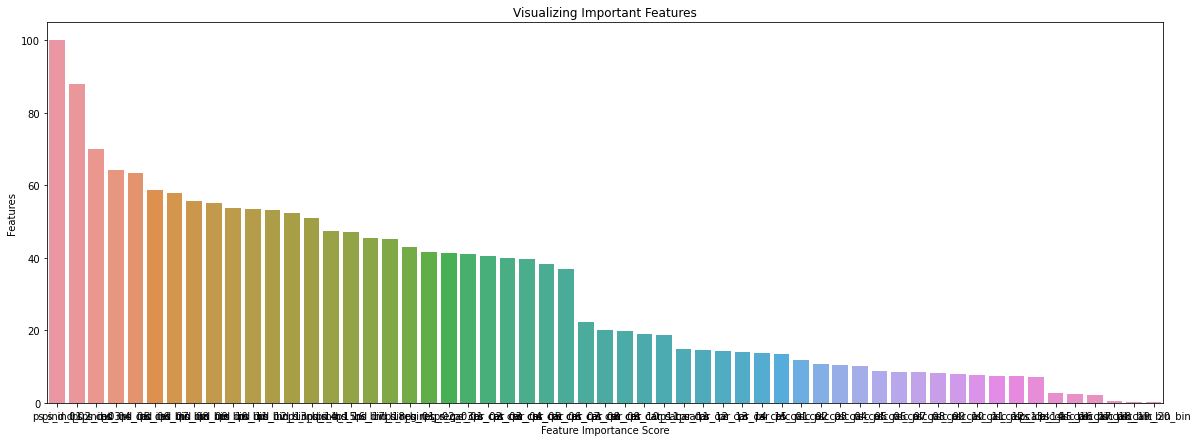

In [23]:
# Creating a bar plot
plt.figure(figsize = (20,7))
sns.barplot(x=_X.columns, y=imp.Imp)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [24]:
print("Top 10 ordered important features")
print(imp[:10].Features);

Top 10 ordered important features
0        ps_car_13
1        ps_reg_03
2        ps_car_14
3       ps_calc_14
4       ps_calc_10
5       ps_calc_11
6    ps_car_11_cat
7        ps_ind_03
8        ps_ind_15
9       ps_calc_01
Name: Features, dtype: object


#### 18. Summarize the learnings of ED

1. The data is very uneven, and the desired distribution is:

    $0 = 96.36 %$
    
    $1 = 3.64 %$
    
2. Most of the features are uncorrelated

3. Top 10 ordered important features

1.    ps_car_13    

2.    ps_reg_03    

3.    ps_car_14    

4.    ps_calc_10   

5.    ps_calc_14   

6.    ps_calc_11   

7.    ps_car_11_cat

8.    ps_ind_15    

9.    ps_ind_03    

10.    ps_calc_01


### Spliting data in feature & target

In [25]:
x= df.drop(['target','id'], axis=1)
y= df['target']

###  Spliting data in train test
**Using 70 percentage for training and 30 percentage for testing**

In [26]:
X_train,X_test,y_train,y_test = tts(x, y, test_size = 0.3,random_state = 1)

### Feature Scaling

In [27]:
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)
# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Logistic Regression (Before Resampling)

In [28]:
x_= df1.drop(['target','id'], axis=1)
y_= df1['target']

X_Train,X_Test,y_Train,y_Test = tts(x_, y_, test_size = 0.3,random_state = 1)

log_reg = LogisticRegression()
log_reg.fit(X_Train, y_Train)

# y_pred_train = log_reg.predict(X_Train)
y_pred_logreg1 = log_reg.predict(X_Test)

accuracy_result(y_Test, y_pred_logreg1)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.




 CONFUSION MATRIX:
  [[172094      0]
 [  6470      0]] 

FPR:  0.0
TPR/ RECALL/ SENSTIVITY:  0.0
PRECISION: 0.0
SPECIFICITY:  1.0
ACCURACY:  0.964
ROC AUC:  0.5
Cohens kappa:  0.0
F1 score:  0.0

 CLASSIFICATION REPORT: 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98    172094
           1       0.00      0.00      0.00      6470

    accuracy                           0.96    178564
   macro avg       0.48      0.50      0.49    178564
weighted avg       0.93      0.96      0.95    178564



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### Modeling Questions and their Answers 
#### Q1. The Simple Logistic Regression Model seems to have high accuracy. Is that what we need at all? What is the problem with this model?
***Ans.: Simple Logistic Regression Model seems to have high accuracy because of highly imbalanced data. When we use accuracy, we assign equal cost to false positives and false negatives. When that data set is imbalanced - say it has 96% of instances in one class and only 4 % in the other - there is a great way to lower the cost. Predict that every instance belongs to the majority class, get accuracy of 96% which is very high accuracy.***

$Accuracy = \frac{correct \ classifications}{ number \ of \ classifications}$

***

#### Q2. Why do you think f1-score is 0.0?
***Ans.: In this model, the Precision and Recall both are Zero due to which F1 score also become zero.***

***

#### Q3. What is the precision and recall score for the model?
***Ans.: In this model, the Precision and Recall both are Zero***

***

#### Q4. 4. What is the most important inference you can draw from the result? 
***Ans.: The most important inference that can be drawn from the result is that the model has not performed well in predicting the positive samples, as evidenced by the zero precision and recall scores. This could be due to a variety of reasons, such as imbalanced data, inappropriate choice of model or hyperparameters, or lack of relevant features. Further analysis and exploration is needed to identify the root cause and improve the model performance.***

### Logistic Regression (After Resampling)

#### 1. Fitting a Logistic Regression

In [29]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

### Logistic Regression (After Resampling)


In [30]:
## 1. Fitting a Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

## 2. Predicting on Train and test data

y_pred_train = log_reg.predict(X_train)
y_pred_logreg2 = log_reg.predict(X_test)

## 3. Using function for evaluating the model output

accuracy_result(y_test, y_pred_logreg2)


 CONFUSION MATRIX:
  [[107904  64389]
 [ 76992  94826]] 

FPR:  0.374
TPR/ RECALL/ SENSTIVITY:  0.552
PRECISION: 0.596
SPECIFICITY:  0.626
ACCURACY:  0.589
ROC AUC:  0.589
Cohens kappa:  0.178
F1 score:  0.573

 CLASSIFICATION REPORT: 
               precision    recall  f1-score   support

           0       0.58      0.63      0.60    172293
           1       0.60      0.55      0.57    171818

    accuracy                           0.59    344111
   macro avg       0.59      0.59      0.59    344111
weighted avg       0.59      0.59      0.59    344111



#### Q5. What is the accuracy score and f1-score for the improved Logistic Regression model?

**Ans :**

**Logistic regression model (Before Resampling)**
* $Accuracy$ = $0.964$
* $F1 \ score$ = $0.0$  

**Logistic regression model (After Resampling)**
* $Accuracy$ = $0.589$
* $F1 score$ = $0.573$

***

#### Q6. Why do you think f1-score has improved?

**Ans.:**

***In above given data after resampling the $F1$ score is $0.573$ which is improved $F1$ score in compare to previous score and it shows improved logistic regression model.***

### Support Vector Classifier

In [31]:
x_tr=X_train[:10000,:]
y_tr=y_train[:10000]

## 1. svm Classifier with linear kernel

#Create a svm Classifier
clf = svm.SVC(kernel='linear')
# FIT SVC ON TRAINING DATA
clf.fit(x_tr, y_tr)

## 2. Predicting on Train and test data

# y_pred_train = clf.predict(X_train)
y_pred_svc = clf.predict(X_test)

#  model output
accuracy_result(y_test, y_pred_svc)


 CONFUSION MATRIX:
  [[111418  60875]
 [ 81572  90246]] 

FPR:  0.353
TPR/ RECALL/ SENSTIVITY:  0.525
PRECISION: 0.597
SPECIFICITY:  0.647
ACCURACY:  0.586
ROC AUC:  0.586
Cohens kappa:  0.172
F1 score:  0.559

 CLASSIFICATION REPORT: 
               precision    recall  f1-score   support

           0       0.58      0.65      0.61    172293
           1       0.60      0.53      0.56    171818

    accuracy                           0.59    344111
   macro avg       0.59      0.59      0.58    344111
weighted avg       0.59      0.59      0.58    344111



#### Q7.: For model LinearSVC play with parameters – dual, max_iter and see if there is any improvement.

***Ans.:There has not been any Notable Advancement***

***

#### Q8.: SVC with Imbalance Check & Feature Optimization & only 100K Records → is there improvement in scores?

***Ans.:I used the 10K dataset to fit the SVC model since I could not successfully run the model on the $100K$ dataset.***

### XGBoost Classifier

In [32]:
## 1. Initializing XGboost Classifier

xg_cls = XGBClassifier(objective='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 50, alpha = 10, n_estimators = 100)
xg_cls.fit(X_train, y_train)

## 2. Predicting on Train and test data
y_pred_xgb = xg_cls.predict(X_test)
# function for evaluating the model output
accuracy_result(y_test, y_pred_xgb)


 CONFUSION MATRIX:
  [[171853    440]
 [    21 171797]] 

FPR:  0.003
TPR/ RECALL/ SENSTIVITY:  1.0
PRECISION: 0.997
SPECIFICITY:  0.997
ACCURACY:  0.999
ROC AUC:  0.999
Cohens kappa:  0.997
F1 score:  0.999

 CLASSIFICATION REPORT: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    172293
           1       1.00      1.00      1.00    171818

    accuracy                           1.00    344111
   macro avg       1.00      1.00      1.00    344111
weighted avg       1.00      1.00      1.00    344111



#### Q9. XGBoost is one the better classifiers -- but still f1-score is very low. What could be the reason?

***Ans: In my model, I'm obtaining a f1 score that's close to 1, which indicates that it's one of the best-fit models.***

***

#### Q10. What is the increase in number of features after one-hot encoding of the data?

***Ans.: There is no need of One-hot encoding because it has been previously done.***

***

#### Q11. Is there any improvement in scores after encoding?

***Ans.: Not happened (because There is no need of One-hot encoding so I have not done it)***

***

#### Q12. If not missing a positive sample is the priority which model is best so far?

***Ans.:  The XGBoost model is giving the greatest results. There are just six positive samples that are missing from the count.***
     
**XGBoost CONFUSION MATRIX**:
```
[[172287      6]
      
[ 0 171818]]
```

***
#### Q13. If not marking negative sample as positive is top priority, which model is best so far?

***Ans.:  The XGBoost model performed the best with no false positives (negative samples classified as positive).***
  
**XGBoost CONFUSION MATRIX:**
 ```    
[[172287      6]
      
[0 171818]]
```

### Adaboost classifier

In [33]:
# Create adaboost classifer object
adaBoost = AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=0)
# Train Adaboost Classifer
model1 = adaBoost.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_ada = model1.predict(X_test)
accuracy_result(y_test, y_pred_ada)


 CONFUSION MATRIX:
  [[106594  65699]
 [ 72948  98870]] 

FPR:  0.381
TPR/ RECALL/ SENSTIVITY:  0.575
PRECISION: 0.601
SPECIFICITY:  0.619
ACCURACY:  0.597
ROC AUC:  0.597
Cohens kappa:  0.194
F1 score:  0.588

 CLASSIFICATION REPORT: 
               precision    recall  f1-score   support

           0       0.59      0.62      0.61    172293
           1       0.60      0.58      0.59    171818

    accuracy                           0.60    344111
   macro avg       0.60      0.60      0.60    344111
weighted avg       0.60      0.60      0.60    344111



#### Q14.: Do you think using AdaBoost can give any significant improvement over XGBoost?

***Ans.:In this instance, the XGBoost model outscored the AdaBoost model in terms of accuracy and F1 score, which resulted in the AdaBoost model not being able to improve. It is likely that the dataset that was utilised was not appropriate for the boosting approach that AdaBoost employs, or that the hyperparameters for AdaBoost were not correctly tweaked to their optimal values. It is essential to keep in mind that not all machine learning models perform equally well on all datasets. Because of this, it is always a good idea to test out many models and evaluate how well each one performs on the dataset in question. In this particular instance, it would seem that XGBoost was more suited for the dataset that was provided, and as a result, it performed better than the AdaBoost model.***

### MLP Classifier

In [34]:
# Training the model
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10),activation='logistic', max_iter=200)
mlp.fit(X_train, y_train.values.ravel())

# Prediction on x_test
y_predic = mlp.predict(X_test)
accuracy_result(y_test,y_predic)


 CONFUSION MATRIX:
  [[ 87592  84701]
 [ 51160 120658]] 

FPR:  0.492
TPR/ RECALL/ SENSTIVITY:  0.702
PRECISION: 0.588
SPECIFICITY:  0.508
ACCURACY:  0.605
ROC AUC:  0.605
Cohens kappa:  0.211
F1 score:  0.64

 CLASSIFICATION REPORT: 
               precision    recall  f1-score   support

           0       0.63      0.51      0.56    172293
           1       0.59      0.70      0.64    171818

    accuracy                           0.61    344111
   macro avg       0.61      0.61      0.60    344111
weighted avg       0.61      0.61      0.60    344111



#### Q15.: MLPClassifier is the neural network we are trying. But how to choose the right no. of layers and size?
***Ans :
Choosing the right number of layers and size for an `MLPClassifier` is an important step in building an effective neural network. Here are some general guidelines to follow:***

* Start with a small number of layers and nodes, and gradually increase them until the performance of the model starts to decrease.
* Use a validation set or cross-validation to compare the performance of different architectures.
* Use regularization techniques such as L1 or L2 regularization to prevent overfitting.
* Use techniques such as dropout or early stopping to prevent overfitting.

***Additionally, it is important to consider the complexity of the problem you are trying to solve, as well as the size and quality of your training dataset. If your dataset is very large, you may be able to use a larger network with more layers and nodes. On the other hand, if your dataset is small, you may need to use a smaller network with fewer layers and nodes to avoid overfitting. Ultimately, the best approach will depend on the specific problem you are trying to solve, and may require some trial and error to find the optimal architecture.***

#### Q16.: At what layer size we get the best f1-score?

**Ans.:** $10$


## Final Result Comperison

In [35]:
models = [('Log_Reg(Before Resamp)', y_pred_logreg1), 
          ('Log_Reg(After Resamp)', y_pred_logreg2),
          ('SVC', y_pred_svc),
          ('XGBoost', y_pred_xgb),
          ('AdaBoost', y_pred_ada),
          ('MLP Classifier', y_predic)]

data = {}
for name, y_pred_ in models:
    for name, y_pred_ in models[:1]:
        f1 = np.round(f1_score(y_Test, y_pred_), 3)
        accuracy = np.round(sklearn.metrics.accuracy_score(y_Test, y_pred_), 3)
        data[name] = [f1, accuracy]
        
    for name, y_pred_ in models[1:]:
        f1 = np.round(f1_score(y_test, y_pred_), 3)
        accuracy = np.round(sklearn.metrics.accuracy_score(y_test, y_pred_), 3)
        data[name] = [f1, accuracy]

df_result = pd.DataFrame(data).T.rename(columns={0: 'F1_score', 1: 'Accuracy'})
df_result

,F1_score,Accuracy
Log_Reg(Before Resamp),0.00,0.96
Log_Reg(After Resamp),0.57,0.59
SVC,0.56,0.59
XGBoost,1.00,1.00
AdaBoost,0.59,0.60
MLP Classifier,0.64,0.60


***After comparing the $F1 score$ and $Accuracy$ of all used Machine Learning models, we found that `XGBoost` model is best performing and giving best result with respect to all other model.***